<a href="https://colab.research.google.com/github/VenkyGitRep/AdvancedPerception-ColorConstancy/blob/ColorConstancy_Final/Color_Constancy_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
from google.colab.patches import cv2_imshow

In [ ]:
#Linearises image, returns an image with values in [-1,1].
#Black level is 2048(as in IPG page), saturation level 15k
'''
Image: /content/drive/MyDrive/ColorConstancy/RawImages/CR2_1_100/3.CR2
Black Level per channel: [2048, 2049, 2049, 2049]
Saturation Level: 15831
'''
#Linearize images
def linearize(img, black_lvl=2048, saturation_lvl=15831):

    linearized_img = np.clip((img - black_lvl)/(saturation_lvl - black_lvl), 0, 1)
    scaled_img = (linearized_img * 2) - 1
    return scaled_img


**Resize all images to fit MobileNet input size of (224,224,3)**

In [ ]:
def preprocessImage(png_img):
  return cv2.resize(linearize(png_img), (224, 224), interpolation=cv2.INTER_LINEAR)


**Linearize all png images**

In [ ]:
#preprocessImagesInDirectory
def preprocessImagesInDirectory(image_directory):
  resized_linear_images = []
  # List of image paths
  image_paths = [os.path.join(image_directory, file) for file in os.listdir(image_directory) if file.endswith(('.PNG'))]

  print(len(image_paths))
  print(image_paths)

  for i in range(len(image_paths)):
      raw_img= cv2.imread(image_paths[i], cv2.IMREAD_UNCHANGED)
      raw_img_rbg = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB).astype(np.float64)
      resized_linear_images.append(preprocessImage(raw_img_rbg))
      #if i==100:
        #break
      print(i,end=' ')
      if(i%20==0):
        print()
      #cv2.imwrite(f"/content/drive/MyDrive/ColorConstancy/LinearizedRawImages/{i}.png", linearized_image)
  return resized_linear_images

resized_linear_images = preprocessImagesInDirectory("/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/")


600
['/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/1.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/2.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/4.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/3.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/6.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/7.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/8.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/9.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/11.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/12.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/13.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/14.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/16.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/17.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/18.PNG', '/content/drive/MyDrive/ColorConstancy/Cube

In [ ]:
print(resized_linear_images[0].shape)

(224, 224, 3)


**Save preprocessed images**

In [ ]:
# Save the linearized image as a .npy file

def saveNPArray(filename,array):
  # Define the directory where you want to save the file
  save_directory = "/content/drive/MyDrive/ColorConstancy/PreprocessesImages/"

  # Check if the directory exists, if not, create it
  if not os.path.exists(save_directory):
      os.makedirs(save_directory)

  # Define the full path for the .npy file
  file_path = os.path.join(save_directory, filename)

  # Save the linearized image as a .npy file in the specified directory
  np.save(file_path, array)

saveNPArray("linearized_raw_image_nparray.npy",resized_linear_images)

In [ ]:
# Later, you can load the image back from that directory
loaded_linearised_images = np.load("/content/drive/MyDrive/ColorConstancy/PreprocessesImages/linearized_raw_image_nparray.npy")

In [ ]:
# Compute the difference
difference = np.abs(resized_linear_images - loaded_linearised_images)
print(difference.max())

0.0


**Check is loaded resized images are actual images**

In [ ]:
len(loaded_linearised_images)

600

In [ ]:
loaded_linearised_images[0].shape

(224, 224, 3)

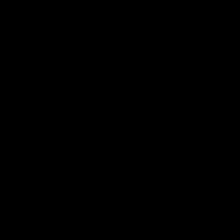

In [ ]:
#This image has not been color corrected using illumination values.
cv2_imshow(loaded_linearised_images[0])

In [ ]:
#Applying illumination values.
def applyIlluminationOnLinearizedImage(cam):
  cam2rgb = np.array([
          1.8795, -1.0326, 0.1531,
          -0.2198, 1.7153, -0.4955,
          0.0069, -0.5150, 1.5081,]).reshape((3, 3))
  illum = np.array([0.16238344,0.45326359, 0.38435297])

  cam_wb = np.clip(cam/illum, 0, 1)
  rgb = np.dot(cam_wb, cam2rgb.T)
  rgb = np.clip(rgb, 0, 1)**(1/2.2)
  return (rgb*255).astype(np.uint8)


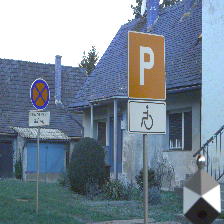

In [ ]:
cv2_imshow(applyIlluminationOnLinearizedImage((loaded_linearised_images[0]+1)/2))

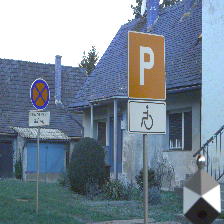

In [ ]:
image_path = "/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/1.PNG"

new_resized_img = preprocessImage(cv2.cvtColor(cv2.imread(image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB).astype(np.float64))
cv2_imshow(applyIlluminationOnLinearizedImage((new_resized_img+1)/2))

**This is what is happening** : The preprocess method, linearises and rescales to a value of [-1,1], to display the image, i''ll have to rescale to [0,1] and then apply the illumination values to look at the color image.

**Load ground truth values: Illumination values for PNG image**

In [ ]:
#Getting grount truth illumination values
file_path = '/content/drive/MyDrive/ColorConstancy/cube+_gt.txt'

illuminant_true_values = []

with open(file_path, 'r') as file:
    for i, line in enumerate(file):
      values = line.strip().split()
      if len(values) == 3:
            illuminant_true_values.append([float(value) for value in values])


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras import layers,models
import tensorflow as tf


In [ ]:


# Define a custom regression model based on MobileNetV2
def create_model():
    base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
    for layer in base_model.layers:
        layer.trainable = False  # Freeze the pretrained layers

    # Add custom layers for regression
    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    output = layers.Dense(3, activation='linear')(x)  # Output layer with 3 units for RGB illuminant values

    model = models.Model(inputs=base_model.input, outputs=output)

    return model

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Create a data generator using tf.data.Dataset
batch_size = 32  # Adjust batch size as needed
# Convert the lists to TensorFlow tensors
linearised_png_images_tensor = tf.convert_to_tensor(loaded_linearised_images, dtype=tf.float64)
illuminant_true_values_tensor = tf.convert_to_tensor(illuminant_true_values[0:len(loaded_linearised_images)], dtype=tf.float64)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((linearised_png_images_tensor, illuminant_true_values_tensor))

# Optionally, you can add dataset operations such as batching, shuffling, etc.
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size=32)

# Train the model
num_epochs = 400  # Adjust the number of training epochs
history = model.fit(train_dataset, epochs=num_epochs, verbose=1)

9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/400
19/19 [==============================] - 12s 39ms/step - loss: 0.3448
Epoch 2/400
19/19 [==============================] - 1s 29ms/step - loss: 0.0420
Epoch 3/400
19/19 [==============================] - 1s 29ms/step - loss: 0.0186
Epoch 4/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0127
Epoch 5/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0105
Epoch 6/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0090
Epoch 7/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0079
Epoch 8/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0071
Epoch 9/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0065
Epoch 10/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0060
Epoch 11/400
19/19 [==============================] - 1s 28ms/step - loss: 0.0055
Epoch 12/400
19/19 [=======================

**Make a prediction**


In [ ]:
test_png_imag_path="/content/drive/MyDrive/ColorConstancy/TestImages/1001.PNG"

#Perform preprocessing:
png_img=cv2.imread(test_png_imag_path, cv2.IMREAD_UNCHANGED)
raw_img_rbg = cv2.cvtColor(png_img, cv2.COLOR_BGR2RGB).astype(np.float64)
resized_linear_image = preprocessImage(png_img)

In [ ]:

# Make predictions

# Expand dimensions to match the shape of (batch_size, height, width, channels)
img_batch = np.expand_dims(resized_linear_image, axis=0)

# Predict the values using the trained model
predictions = model.predict(img_batch)

predictions


1/1 [==============================] - 1s 860ms/step


array([[0.19069847, 0.42111856, 0.31255716]], dtype=float32)

1001.PNG GT       :[0.23895582 0.47590361 0.28514056]

First prediction  : [0.46585822, 0.7702673 , 0.03647143]

Second prediction : [0.2062704 , 0.24868996, 0.08920331]

Third prediction  : [0.20485055, 0.4598795 , 0.3357277 ]

**Preprocess test images**

In [ ]:
linearized_test_images = preprocessImagesInDirectory("/content/drive/MyDrive/ColorConstancy/TestImages")
saveNPArray("linearized_test_images_nparray.npy",linearized_test_images)

200
['/content/drive/MyDrive/ColorConstancy/TestImages/1002.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1003.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1004.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1006.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1007.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1008.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1009.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1012.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1011.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1013.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1014.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1016.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1018.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1017.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1019.PNG', '/content/drive/MyDrive/ColorConstancy/TestImages/1021.PNG', '/content/drive/MyD

**Predictions made with 200 test images**

In [ ]:
# Create a data generator for inference
inference_dataset = tf.data.Dataset.from_tensor_slices(linearized_test_images)
inference_dataset = inference_dataset.batch(batch_size)

# Make predictions
predictions= model.predict(inference_dataset)
predictions.shape


7/7 [==============================] - 1s 55ms/step


(200, 3)

**Metrics**

In [ ]:
def angularError(true_illumination, prediction):
  # Normalize the vectors
    true_color_normalized = true_illumination / np.linalg.norm(true_illumination)
    estimated_color_normalized = prediction / np.linalg.norm(prediction)

    # Compute the dot product
    dot_product = np.dot(true_color_normalized, estimated_color_normalized)

    # Clip the dot product to avoid numerical issues with arccos
    dot_product = np.clip(dot_product, -1.0, 1.0)

    # Compute the angular error in radians
    angle_rad = np.arccos(dot_product)

    # Convert the angular error to degrees
    angle_deg = np.degrees(angle_rad)

    return angle_deg




In [ ]:
angularError(illuminant_true_values[1001],predictions[0])

7.889316484137091

**Summary statistics**

In [ ]:
import statistics

def summary_statistics(angular_errors):
    # Step 1: Sort the array
    sorted_arr = np.sort(angular_errors)

    # Step 2: Calculate Q1 (25th percentile)
    q1 = np.percentile(sorted_arr, 25)

    # Step 3: Calculate Q3 (75th percentile)
    q3 = np.percentile(sorted_arr, 75)

    # Step 4: Calculate the median (50th percentile)
    median = statistics.median(sorted_arr)

    # Step 5: Calculate the trimean
    trimean = (q1 + 2 * median + q3) / 4

    # Step 6: Calculate the average of the lowest 25% of values
    lower_25_avg = np.mean(sorted_arr[:len(sorted_arr)//4])

    # Step 7: Calculate the average of the highest 25% of values
    upper_25_avg = np.mean(sorted_arr[-(len(sorted_arr)//4):])

    # Step 8: Calculate the overall mean
    overall_mean = np.mean(sorted_arr)

    # Print the results
    print("Mean:", overall_mean,end='\n')
    print("Median:", median,end='\n')
    print("Trimean:", trimean,end='\n')
    print("Average of the Lowest 25%:", lower_25_avg,end='\n')
    print("Average of the Highest 25%:", upper_25_avg,end='\n')


In [ ]:
type(illuminant_true_values[1001:1201])

list

In [ ]:
type(predictions)

numpy.ndarray

In [ ]:
# Compute the angular error for each pair of true and predicted illuminations
angular_errors = [angularError(true_ill, pred_ill) for true_ill, pred_ill in zip(np.array(illuminant_true_values[1001:1201]), predictions)]
summary_statistics(angular_errors)

Mean: 8.264422765445584
Median: 5.234855505697087
Trimean: 6.011737245778948
Average of the Lowest 25%: 1.5518983268750923
Average of the Highest 25%: 20.25450179694734


**Compile model with Angular error**

In [ ]:
def angular_error_loss(y_true, y_pred):
    y_true_norm = tf.nn.l2_normalize(y_true, axis=1)
    y_pred_norm = tf.nn.l2_normalize(y_pred, axis=1)
    dot_product = tf.reduce_sum(tf.multiply(y_true_norm, y_pred_norm), axis=1)
    #dot_product = tf.clip_by_value(dot_product, -1.0, 1.0)

    dot_product_checked = tf.debugging.check_numerics(dot_product, "dot_product")
    angle_rad = tf.acos(dot_product_checked)


    angle_rad = tf.acos(dot_product)
    angle_deg = tf.math.scalar_mul(tf.constant(180.0 / np.pi, dtype=tf.float32), angle_rad)
    return angle_deg

In [ ]:

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [ ]:
# Train the model
num_epochs = 200  # Adjust the number of training epochs
history = model.fit(train_dataset, epochs=num_epochs, verbose=1)

Epoch 1/200
19/19 [==============================] - 1s 28ms/step - loss: 1.0322e-04
Epoch 2/200
19/19 [==============================] - 1s 27ms/step - loss: 1.1665e-04
Epoch 3/200
19/19 [==============================] - 1s 28ms/step - loss: 1.0098e-04
Epoch 4/200
19/19 [==============================] - 1s 28ms/step - loss: 9.7617e-05
Epoch 5/200
19/19 [==============================] - 1s 28ms/step - loss: 1.5528e-04
Epoch 6/200
19/19 [==============================] - 1s 28ms/step - loss: 2.1385e-04
Epoch 7/200
19/19 [==============================] - 1s 28ms/step - loss: 2.3246e-04
Epoch 8/200
19/19 [==============================] - 1s 28ms/step - loss: 2.7277e-04
Epoch 9/200
19/19 [==============================] - 1s 28ms/step - loss: 3.4999e-04
Epoch 10/200
19/19 [==============================] - 1s 28ms/step - loss: 4.2461e-04
Epoch 11/200
19/19 [==============================] - 1s 27ms/step - loss: 3.3027e-04
Epoch 12/200
19/19 [==============================] - 1s 28ms/s

In [ ]:
#
predictions

In [ ]:
# Compute the angular error for each pair of true and predicted illuminations
angular_errors = [angularError(true_ill, pred_ill) for true_ill, pred_ill in zip(np.array(illuminant_true_values[1001:1201]), predictions)]
summary_statistics(angular_errors)

Mean: 8.264422765445584
Median: 5.234855505697087
Trimean: 6.011737245778948
Average of the Lowest 25%: 1.5518983268750923
Average of the Highest 25%: 20.25450179694734


#Things
->Data Augmentation : Mutiply each channel by random coefficient.
Eg:Compute Minmax of each channel, get min and max. compute a cofficient so that pixel values arent saturated.
All images in dataset get multiplied by this set of generated coefficients.

In [ ]:
#Takes image channel, and calcualtes random Multiplier.
def getRandomMultiplier(image_channel):
  current_min, current_max = np.min(image_channel), np.max(image_channel)

  # Specified target range
  target_min = 2048
  target_max = 15831

  # Calculating the range for the multiplier
  max_multiplier = target_max / current_max
  min_multiplier = target_min / current_min if current_min != 0 else 0
  # Generating a random multiplier within the range
  random_multiplier = np.random.uniform(min_multiplier, max_multiplier)
  return random_multiplier


In [ ]:
#Multiply each image channel by a randomly generated coefficiet
def performAugmentation(image):
    # Get the minimum and maximum values for each channel

    # Splitting the image into its respective channels
    red_channel, green_channel, blue_channel = cv2.split(image)

    # Finding the minimum and maximum values for each channel
    min_blue, max_blue = np.min(blue_channel), np.max(blue_channel)
    min_green, max_green = np.min(green_channel), np.max(green_channel)
    min_red, max_red = np.min(red_channel), np.max(red_channel)

    red_random_coefficient = getRandomMultiplier(red_channel)
    green_random_coefficient = getRandomMultiplier(green_channel)
    blue_random_coefficient = getRandomMultiplier(blue_channel)

    # Multiply each channel by its respective coefficient
    blue_channel = blue_channel * blue_random_coefficient
    green_channel = green_channel * green_random_coefficient
    red_channel = red_channel * red_random_coefficient

    # Merge the channels back into an image
    modified_image = cv2.merge([blue_channel, green_channel, red_channel])
    return red_random_coefficient, green_random_coefficient, blue_random_coefficient,modified_image

In [ ]:
#Update target Illumination values
def updateIlluminationValues(illuminant_true_values,rgb_random_coeffs):
  print("True values:", illuminant_true_values[0:10])
  augmented_illumination_true_values = []
  for i in range(len(rgb_random_coeffs)):
    #Divide each illumination value by rgb_coefficient
    #print(illuminant_true_values[i], ":", rgb_random_coeffs[i])
    #divide each value in illuminant_true_values by respective value in rgb_random_coeffs
    current_augmented_illumination_true_values = []
    for j in range(len(illuminant_true_values[i])):
      current_augmented_illumination_true_values.append(illuminant_true_values[i][j]/rgb_random_coeffs[i][j])
    augmented_illumination_true_values.append(current_augmented_illumination_true_values)
  print("Augmented_true_values:",augmented_illumination_true_values)
  print(len(augmented_illumination_true_values))
  return augmented_illumination_true_values

In [ ]:
#preprocessImagesInDirectory
def dataAugmentation(image_directory):
  resized_linear_augmented_images = []
  rgb_random_coeffs = []
  # List of image paths
  image_paths = [os.path.join(image_directory, file) for file in os.listdir(image_directory) if file.endswith(('.PNG'))]

  print(len(image_paths))
  print(image_paths)

  for i in range(len(image_paths)):
      raw_img= cv2.imread(image_paths[i], cv2.IMREAD_UNCHANGED)
      raw_img_rbg = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB).astype(np.float64)
      r_coeff, g_coeff, b_coeff, modified_image=performAugmentation(raw_img_rbg)
      resized_linear_augmented_images.append(preprocessImage(raw_img_rbg))
      rgb_random_coeffs.append([r_coeff,g_coeff,b_coeff])
      #if i==10:
        #break
      print(i,end=' ')
      if(i%20==0):
        print()
      #cv2.imwrite(f"/content/drive/MyDrive/ColorConstancy/LinearizedRawImages/{i}.png", linearized_image)
  print(rgb_random_coeffs)

  #Write rgb_random_coeffs to file
  with open("/content/drive/MyDrive/ColorConstancy/rgb_random_coeffs.txt", "w") as f:
    for item in rgb_random_coeffs:
      f.write("%s\n" % item)

  return rgb_random_coeffs,resized_linear_augmented_images

rgb_random_coeffs,resized_linear_augmented_images = dataAugmentation("/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/")
augmented_illumination_true_values = updateIlluminationValues(illuminant_true_values,rgb_random_coeffs)



600
['/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/1.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/2.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/4.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/3.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/6.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/7.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/8.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/9.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/11.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/12.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/13.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/14.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/16.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/17.PNG', '/content/drive/MyDrive/ColorConstancy/CubePlus200Imgs/18.PNG', '/content/drive/MyDrive/ColorConstancy/Cube

In [ ]:
augmented_illumination_true_values = updateIlluminationValues(illuminant_true_values,rgb_random_coeffs)

True values: [[0.16238344, 0.45326359, 0.38435297], [0.20272769, 0.46948682, 0.32778548], [0.2039801, 0.47142337, 0.32459653], [0.20114259, 0.46845989, 0.33039752], [0.47753165, 0.44208861, 0.08037975], [0.20460456, 0.47116414, 0.3242313], [0.21394047, 0.4718901, 0.31416942], [0.19887955, 0.46498599, 0.33613445], [0.21114917, 0.47212706, 0.31672376], [0.38584882, 0.46118605, 0.15296513]]
Augmented_true_values: [[0.13851850076600436, 0.4380883055342826, 0.3393692301911847], [0.18292196468535923, 0.4492035826298354, 0.2313012499741859], [0.1646602402704979, 0.43711874537606876, 0.2704666164953902], [0.17998310204641077, 0.40596055916560775, 0.2916927041957388], [0.44379740069371226, 0.4408559911277269, 0.07727558711313288], [0.1979031257258729, 0.46405005432692203, 0.3209115193148303], [0.11698801859680874, 0.23992766877991384, 0.17603357788542903], [0.19183815007091765, 0.4528700788888134, 0.32462818948493555], [0.20388174165878967, 0.4710639372232842, 0.3043867551069549], [0.3735216386

In [ ]:
len(augmented_illumination_true_values)

600

**Train model with augmented images and real images**

In [ ]:
# Later, you can load the image back from that directory
loaded_linearised_images = np.load("/content/drive/MyDrive/ColorConstancy/PreprocessesImages/linearized_raw_image_nparray.npy")

resized_linear_augmented_images_nparray = np.array(resized_linear_augmented_images)
input_images = np.concatenate((loaded_linearised_images, resized_linear_augmented_images_nparray),axis=0)
input_images.shape

(1200, 224, 224, 3)

In [ ]:
#Append illumination values
target_illumination_values = illuminant_true_values[0:len(loaded_linearised_images)]
target_illumination_values = np.array(target_illumination_values)
target_illumination_values = np.concatenate((target_illumination_values, augmented_illumination_true_values),axis=0)
target_illumination_values.shape

(1200, 3)

In [ ]:

# Create the model
model = create_model()

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Create a data generator using tf.data.Dataset
batch_size = 32  # Adjust batch size as needed
# Convert the lists to TensorFlow tensors

linearised_png_images_tensor = tf.convert_to_tensor(input_images, dtype=tf.float64)
illuminant_true_values_tensor = tf.convert_to_tensor(target_illumination_values, dtype=tf.float64)

# Create a TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((linearised_png_images_tensor, illuminant_true_values_tensor))

# Optionally, you can add dataset operations such as batching, shuffling, etc.
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size=32)

# Train the model
num_epochs = 200  # Adjust the number of training epochs
history = model.fit(train_dataset, epochs=num_epochs, verbose=1)

Epoch 1/200
38/38 [==============================] - 4s 28ms/step - loss: 0.1553
Epoch 2/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0157
Epoch 3/200
38/38 [==============================] - 1s 29ms/step - loss: 0.0104
Epoch 4/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0081
Epoch 5/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0070
Epoch 6/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0061
Epoch 7/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0054
Epoch 8/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0050
Epoch 9/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0049
Epoch 10/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0047
Epoch 11/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0044
Epoch 12/200
38/38 [==============================] - 1s 28ms/step - loss: 0.0042
Epoch 13/200
38/38 [=====

In [ ]:
# Create a data generator for inference
inference_dataset = tf.data.Dataset.from_tensor_slices(linearized_test_images)
inference_dataset = inference_dataset.batch(batch_size)

# Make predictions
predictions= model.predict(inference_dataset)
predictions.shape

7/7 [==============================] - 1s 24ms/step


(200, 3)

In [ ]:
# Compute the angular error for each pair of true and predicted illuminations
angular_errors = [angularError(true_ill, pred_ill) for true_ill, pred_ill in zip(target_illumination_values, predictions)]
print("Statistics after Data augmentation:")
summary_statistics(angular_errors)

Statistics after Data augmentation:
Mean: 10.30105101485122
Median: 8.611098013222776
Trimean: 8.741094298579087
Average of the Lowest 25%: 3.1987881068168433
Average of the Highest 25%: 20.59245837093121
